# Vorhersage der Nachfrage von Taxis zu einem bestimmten Zeitpunkt
Aus Sicht eines Taxiunternehmens ist es auch relevant wie viele Taxifahrten generell nachgefragt werden.
Dafür soll dieses Notebook einen kleinen Einblick geben über die Nachfrage nach Taxifahrten zu einem bestimmten Zeitpunkt

In [1]:
import pandas as pd
import dask.dataframe as dd
import os
from datetime import datetime
import warnings
# diese Lib hilft, einige Warnungen zu ignorieren, wenn man z.B. Dataframes lädt
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from matplotlib import pyplot as plt

Zunächst wollen wir unsere kompletten Datensätze durchlaufen und für jede Stunde im Jahr aggregiert vorhersagen, wie viele Taxis benötigt werden

In [2]:
import calendar

bins = pd.DataFrame()
# start_date = datetime.datetime(2020, 5, 17)
# end_date = datetime.datetime(219, , 17)
for index, filename in enumerate(os.listdir('../data/interim/cleaned_csv/')):
    if filename.endswith(".csv"):
        print('Starting with the file:' + filename)
        start_date = datetime(year = 2019, month = index+1, day = 1, hour = 0, minute = 0, second = 0)
        end_date = datetime(year = 2019, month = index+1, day = calendar.monthrange(2019, index+1)[1], hour = 0, minute = 0, second = 0)
        dataframe = dd.read_csv('../data/interim/cleaned_csv/' + os.path.join(filename))
        dataframe = dataframe[(dataframe['tpep_pickup_datetime'] > str(start_date)) & (dataframe['tpep_pickup_datetime'] < str(end_date))].compute()
        times = pd.to_datetime(dataframe['tpep_pickup_datetime'])
        data = dataframe.groupby([times.dt.month, times.dt.day, times.dt.hour])['VendorID'].count()
        bins = pd.concat([bins,data])


Starting with the file:yellow_tripdata_2019-01.csv
Starting with the file:yellow_tripdata_2019-02.csv
Starting with the file:yellow_tripdata_2019-03.csv
Starting with the file:yellow_tripdata_2019-04.csv
Starting with the file:yellow_tripdata_2019-05.csv
Starting with the file:yellow_tripdata_2019-06.csv
Starting with the file:yellow_tripdata_2019-07.csv
Starting with the file:yellow_tripdata_2019-08.csv
Starting with the file:yellow_tripdata_2019-09.csv
Starting with the file:yellow_tripdata_2019-10.csv
Starting with the file:yellow_tripdata_2019-11.csv
Starting with the file:yellow_tripdata_2019-12.csv


# Data Preprocessing
Anhand der gegroupten Werte könen wir unsere Datenframe erstellen.
Wir konzentrieren uns nur auf die Zeitwerte, d.h. Monat, Wochentag und Stunde

In [5]:
binned_dataframe_2019 = pd.DataFrame()
for index, row in bins.iterrows():
    date = datetime(year = 2019, month = index[0], day = index[1])
    d = {'month': [index[0]], 'weekday': [date.weekday()], 'hour': [index[2]], 'counted_taxi_drives': [row[0]] }
    binned_dataframe_2019 = pd.concat([binned_dataframe_2019, pd.DataFrame(data=d)])
binned_dataframe_2019.to_csv('../data/processed/binned_dataframe_to_hours.csv', index=False)
binned_dataframe_2019

,month,weekday,hour,counted_taxi_drives
0,1,1,0,13207.0
0,1,1,1,15182.0
0,1,1,2,12955.0
0,1,1,3,10204.0
0,1,1,4,6666.0
...,...,...,...,...
0,12,0,19,9304.0
0,12,0,20,7938.0
0,12,0,21,8182.0
0,12,0,22,7276.0


Wir definieren unsere Features: ['month', 'weekday', 'hour']
Unser Target ist dabei 'counted_taxi_drives'

In [10]:
features = ['month', 'weekday', 'hour']
columns = ['month', 'weekday', 'hour', 'counted_taxi_drives']
scaled_data = pd.read_csv('../data/processed/binned_dataframe_to_hours.csv')
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_data[columns] = scaler.fit_transform(binned_dataframe_2019[columns])
# output transformed data
scaled_data.head()


,month,weekday,hour,counted_taxi_drives
0,0.0,0.166667,0.000000,0.613453
1,0.0,0.166667,0.043478,0.708620
2,0.0,0.166667,0.086957,0.601311
3,0.0,0.166667,0.130435,0.468752
4,0.0,0.166667,0.173913,0.298270


In [16]:
# split data into train and test sets
X = scaled_data[features]
y = scaled_data["counted_taxi_drives"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
X_train = X_train[features]
X_test = X_test[features]

In [17]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = np.round(lm.predict(X_test), 2)
lm_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
lm_train_rmse = np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
lm_variance = abs(lm_train_rmse - lm_rmse)
print("Test RMSE for Linear Regression is ", lm_rmse)
print("Train RMSE for Linear Regression is ", lm_train_rmse)
print("Variance for Linear Regression is ", lm_variance)

Test RMSE for Linear Regression is  0.16434937509383976
Train RMSE for Linear Regression is  0.16496093369169346
Variance for Linear Regression is  0.0006115585978536953


In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=883, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(rf_pred, y_test))
print(rf.score(X_test, y_test))
print("RMSE for Random Forest is ", rf_rmse)

0.9008253349959691
RMSE for Random Forest is  0.07287466748087247


month = 0.05164626888198808
weekday = 0.12621857310729212
hour = 0.8221351580107198


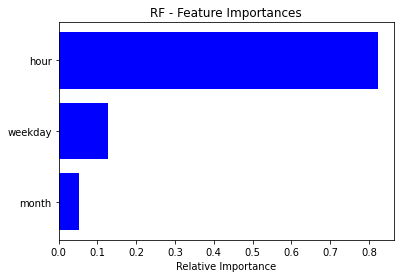

In [19]:
for name, importance in zip(features, rf.feature_importances_):
    print(name, "=", importance)

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('RF - Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
train_data = lgb.Dataset(X_train, label=y_train)
param = {'num_leaves': 31, 'num_trees': 5000, 'objective': 'regression'}
param['metric'] = 'l2_root'
num_round = 5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10, verbose_eval=20, early_stopping_rounds=20,
                    stratified=False)
lgb_bst = lgb.train(param, train_data, len(cv_results['rmse-mean']))
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ", lgb_rmse)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 5715, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 5715, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data po

# Testen von Predictions

test_data: 
   month weekday hour
0     2       0    2
Linear Regression:  5664.25  Nachfrage nach Taxifahrten
Random Forest:  1410.8648968253967  Nachfrage nach Taxifahrten
LightGBM:  1364.808528463197  Nachfrage nach Taxifahrten


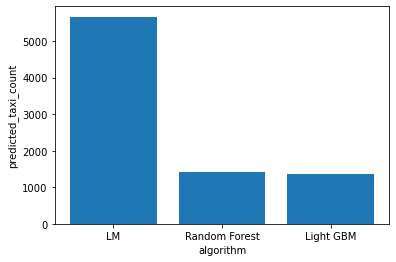

In [30]:
def get_pred(algo, dataset):
    scaled_test_data = scaler.transform([dataset])[0][:-1]
    df_test = pd.DataFrame([scaled_test_data],
                           columns=[features])
    if algo == lm:
        test_pred_scaled = np.append(scaled_test_data, np.round(algo.predict(df_test), 2))
    else:
        test_pred_scaled = np.append(scaled_test_data, algo.predict(df_test))

    test_pred = scaler.inverse_transform([test_pred_scaled])[0][3]
    return test_pred

def get_input(text: str, range_start: int, range_end: int) -> int:
    result = 0
    while not result in range(range_start, range_end):
        result = int(input(text))
    return result


if input("Hier können Einzeldaten fürs Testen eingegeben werden \n Bei nein oder bei Enter werden Standardwerte genutzt \n custom input: (y or N)") == "y":
    test_data = [get_input(text="Pickup Month (1 <= x <= 12): ", range_start=1, range_end=12),
                 get_input(text="Weekday (0 <= x <= 6): ", range_start=0, range_end=6),
                 get_input(text="Pickup Hour (1 <= x <= 23): ", range_start=1, range_end=23), 0]
else:
    test_data = [4, 1, 12, 0]

lm_test_pred = get_pred(algo=lm, dataset=test_data)
rf_test_pred = get_pred(algo=rf, dataset=test_data)
lgb_test_pred = get_pred(algo=lgb_bst, dataset=test_data)

print("test_data: \n", pd.DataFrame([test_data[:-1]],
                                    columns=[features]).head())
print("Linear Regression: ", lm_test_pred, " Nachfrage nach Taxifahrten")
print("Random Forest: ", rf_test_pred, " Nachfrage nach Taxifahrten")
print("LightGBM: ", lgb_test_pred, " Nachfrage nach Taxifahrten")

# bar chart
height = [lm_test_pred, rf_test_pred, lgb_test_pred]
bars = ('LM', 'Random Forest', 'Light GBM')
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, height)
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.ylabel('predicted_taxi_count')
plt.xlabel('algorithm')
# Show graphic
plt.show()

# Ausblick
Die Performance der unterschiedlichen Modelle ist noch nicht besonders gut.
Hier haben wir im Anbetracht der Zeit kein Tuning mehr gemacht allerdings wollen wir einen Ausblick geben:
Zunächst einmal könnten wir uns vorstellen das Dataframe um weiter Features zu erweitern.
Angedacht sind hier Wetterdaten, die eine Nachfrage nach Taxis beeinflussen könnten.
bsp. mehr Fahrten bei Regen oder Kälte. Hierfür fehlten uns allerdings die benötigten Daten, um eine solche Erweiterung der Features zu ermöglichen.
Ein weiteres Feature wäre zudem die Pickup Location, sodass wir auch unterscheiden könnten zwischen der Nachfrage in unterschiedlichen Regionen.
Beispielsweise in einem Gewerbegebiet eher morgens und abens und in einem Gebiet mit vielen Clubs und Restaurant eher später Abend oder Nacht